In [1]:
import torch
import torch.nn as nn
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import pickle
import torch.nn.functional as F
import pandas as pd
import sys
sys.path.append('..')
from helpers import *

In [6]:
vocab_dim = 100
maxlen = 20  # Maximum length of text retention
   
embedding_weights = np.load("Word2VecArray.npy") 
# Set a zero vector for words that do not appear in the vocabulary
embedding_weights = np.r_[np.zeros((1, vocab_dim)),embedding_weights]

f = open("../Glove/vocab.pkl", 'rb') 
index_dict = pickle.load(f)    # index dictionary {'word': idx}

# Index each word + 1 because of the zero vector
for key, value in index_dict.items():  
    index_dict[key] = value + 1 

pos_ = pd.read_csv("../part_pos.csv")
neg_ = pd.read_csv("../part_neg.csv")
 
pos_data = pos_['tweet'].tolist()
neg_data = neg_['tweet'].tolist()
data = neg_data + pos_data

label_list = ([0] * len(neg_data) + [1] * len(pos_data))

In [7]:
####LSTM####
train_x,val_x,train_y,val_y = train_test_split(data, label_list, test_size=0.05)
train_x = text_to_index_array(index_dict, train_x)
val_x = text_to_index_array(index_dict, val_x)
train_y = np.array(train_y) 
val_y = np.array(val_y)

In [8]:
from torch.nn.utils.rnn import pad_sequence

# Cut the data to the same specified length 
train_x = pad_sequence([torch.from_numpy(np.array(x)) for x in train_x],batch_first=True).float() 
val_x = pad_sequence([torch.from_numpy(np.array(x)) for x in val_x],batch_first=True).float()
train_x = text_cut_to_same_long(train_x)
val_x = text_cut_to_same_long(val_x)

# Index to vector
train_x = creat_wordvec_tensor(embedding_weights,train_x)
val_x = creat_wordvec_tensor(embedding_weights,val_x)

print("train shape： ", train_x.shape)
print("val shape： ", val_x.shape)

train shape：  (172227, 20, 100)
val shape：  (9065, 20, 100)


In [ ]:
batch_size = 128

from torch.utils.data import TensorDataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
  

In [16]:
    
class BiLSTM_Attention(nn.Module):
    def __init__(self):

        super(BiLSTM_Attention, self).__init__()
        self.hidden_size = 128
        self.input_size = vocab_dim
        self.layer_size = 3
        self.lstm = nn.LSTM(self.input_size,
                            self.hidden_size,
                            self.layer_size,
                            batch_first=True,
                            bidirectional=True
                            )
        self.out = nn.Linear(self.hidden_size*2, 2)

    def attention_net(self,lstm_output, final_state):
        # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
        # final_state : [num_layers(=2) * num_directions(=2), batch_size, n_hidden]
        batch_size = len(lstm_output)
        # hidden = final_state.view(batch_size,-1,1)
        hidden = torch.cat((final_state[0],final_state[1]),dim=1).unsqueeze(2)
        # hidden : [batch_size, n_hidden * num_directions(=2), n_layer(=2)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights,1)

        # context: [batch_size, n_hidden * num_directions(=2)]
        context = torch.bmm(lstm_output.transpose(1,2),soft_attn_weights.unsqueeze(2)).squeeze(2)

        return context, soft_attn_weights

    def forward(self, input):

        output, (final_hidden_state, final_cell_state) = self.lstm(input)

        attn_output, attention = self.attention_net(output,final_hidden_state)
        return self.out(attn_output),attention # attn_output : [batch_size, num_classes], attention : [batch_size, n_step]

     
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(
            input_size=vocab_dim,
            hidden_size=128,
            num_layers=3,
            batch_first=True)   

    def forward(self, x):
        out, (h_0, c_0) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = torch.sigmoid(out)    
        return out, h_0    

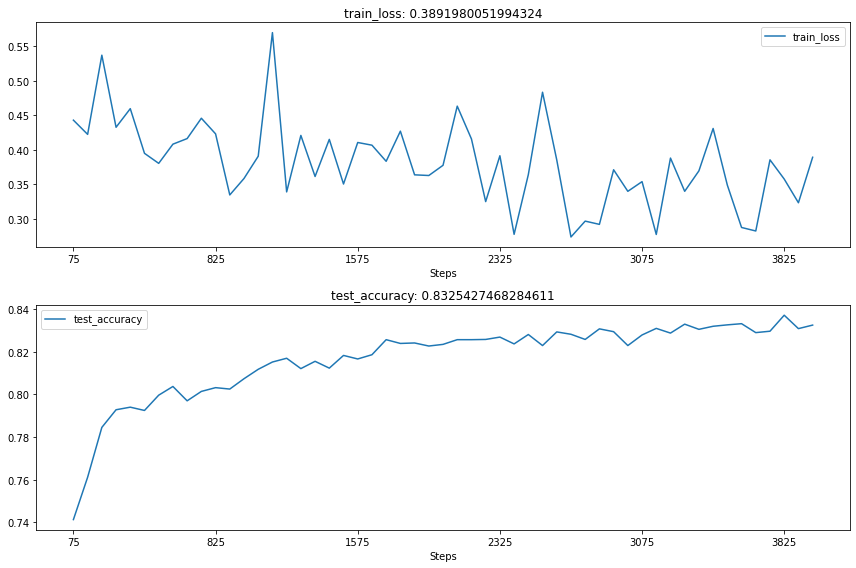

epoch:2 accuracy：84.285% loss = 0.34318365412383695


In [19]:
####------train---------####
from sklearn.metrics import accuracy_score, classification_report
import hiddenlayer as hl

model = BiLSTM_Attention()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
logStep=75
n_epoch = 3

print ('————————train————————')
history1=hl.History()
canvas1=hl.Canvas()

for epoch in range(n_epoch):
    correct = 0
    total = 0
    epoch_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):        

        data = torch.as_tensor(data, dtype=torch.float32)
        target = target.long()   
        optimizer.zero_grad()
        data,target = data.cuda(),target.cuda()  
        output, h_state = model(data)
        #labels = output.argmax(dim= 1)
        #acc = accuracy_score(target, labels)
        
        correct += int(torch.sum(torch.argmax(output, dim=1) == target))
        total += len(target)
        
        optimizer.zero_grad()
        loss = F.cross_entropy(output, target) 
        epoch_loss += loss.item()
        loss.backward() 
        optimizer.step()

        niter=epoch*len(train_loader)+batch_idx+1
        if niter % logStep ==0:
            val_x = torch.as_tensor(val_x, dtype=torch.float32)
            val_x = val_x.cuda() 
            output,_= model(val_x)
            pre_lab=torch.argmax(output, dim=1)
            test_accuracy=accuracy_score(val_y,pre_lab.cpu())
            history1.log(niter,train_loss=loss,test_accuracy=test_accuracy)
            with canvas1:
                canvas1.draw_plot(history1['train_loss'])
                canvas1.draw_plot(history1['test_accuracy'])
    
    loss = epoch_loss / (batch_idx + 1)
    print ('epoch:%s'%epoch, 'accuracy：%.3f%%'%(correct *100 / total), 'loss = %s'%loss)
    

In [20]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/W2V_BiLSTM_attn.pt')